<a href="https://colab.research.google.com/github/M-Zia-Khan/datascience/blob/master/lab_0_DPN92_PyTorch_SeedLings_Google_Collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install PyTorch on Google Collborator

# Tel-Aviv Deep Learning Boot-camp: 12 Applied Deep Learning Labs
# GOOGLE COLLBORATOR VERSION (WIP) KAGGLE + DUAL PATH NETWORK (DPN92)

# Git version: https://github.com/bayesianio/applied-dl-2018/blob/master/lab-0-SeNet-SeedLings.ipynb

## Links:

- https://www.meetup.com/Tel-Aviv-Deep-Learning-Bootcamp/ 
- Git: https://github.com/bayesianio/applied-dl-2018
- Full info: https://www.evernote.com/shard/s341/sh/3855640e-2b0b-42e5-b5b9-00216d02ac9a/b47968226e49a81ee813901cd41d3924


## Google Colab links:
- https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d
- https://jovianlin.io/pytorch-with-gpu-in-google-colab/

## Lab 0: Plant Seedlings Classification (PyTorch): 


### Instructors:

- Shlomo Kashani: shlomo@bayesian.io ,
- Nathaniel Shimoni nathaniel.shimoni@grid4c.com 


## Progress

- [x] Download Kaggle cli
- [x] Download Seedlings DataSet using the command line
- [x] PyTorch DataSet
- [x] PyTorch DataLoader
- [x] Augmentations
- [x] Simple CNN
- [x] Training + train test split
- [x] TensorBoard Support from PyTorch
- [x] Accuray and Log Loss
- [x] Tqdm progress
- [x] Persisting the model
- [x] Testing on a test set



### Requirements:
- Python 3.5, CUDA 9, cuDNN 7, PyTorch 2.0 or above, Keras 2 or above

#### For Windows 10 and Windows Server 2016, CUDA 9
`conda install -c peterjc123 pytorch cuda90`


### Data
- Download: https://www.kaggle.com/c/plant-seedlings-classification

- Please make sure you have already set up a Pytorch tree structure of your dataset:
- `data_dir= '/home/data/bone/train/' `

```
    data_dir= '/home/data/bone/train/
    
    ├── valid
    │   └── Type_1
        ├── Type_2
        └── Type_3
    └── train
        ├── Type_1
        ├── Type_2
        └── Type_3
```

### PyTorch Datasets

To create a dataset, we subclass Dataset and define a constructor, a `__len__` method, and a `__getitem__` method. 
Here is full example:

```python
class BoneDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        img_name = self.labels.iloc[idx, 0] # file name
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname).convert('RGB')
        labels = self.labels.iloc[idx, 2] # category_id
        if self.transform:
            image = self.transform(image)
        return image, labels
```

### The PyTorch DataLoader Class¶
- Will load our BoneDataset
- Can be regarded as a list (or iterator, technically).
- Each time it is invoked will provide a minibatch of (img, label) pairs.


In [0]:
!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
!pip3 install torchvision
!pip3 install tqdm

    100% |████████████████████████████████| 592.3MB 60.7MB/s 
    100% |████████████████████████████████| 51kB 2.8MB/s 
    100% |████████████████████████████████| 5.9MB 239kB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 61kB 4.6MB/s 


In [0]:
# Google specific code

# !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
# !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
# !apt-get update -qq 2>&1 > /dev/null
# !apt-get -y install -qq google-drive-ocamlfuse fuse
# from google.colab import auth
# auth.authenticate_user()
# from oauth2client.client import GoogleCredentials
# creds = GoogleCredentials.get_application_default()
# import getpass
# !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
# vcode = getpass.getpass()
# !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# !mkdir -p med-drive
# !google-drive-ocamlfuse med-drive

In [0]:
%reset -f 
%matplotlib inline


import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random 


import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
# call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

use_cuda = torch.cuda.is_available()
# use_cuda = False

print("USE CUDA=" + str (use_cuda))
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

manualSeed = None
def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if manualSeed is None:
        manualSeed = 999
fixSeed(manualSeed)



__Python VERSION: 3.6.3 (default, Oct  3 2017, 21:45:48) 
[GCC 7.2.0]
__pyTorch VERSION: 0.3.0.post4
__CUDA VERSION
/bin/sh: 1: nvcc: not found
__CUDNN VERSION: 7003
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
USE CUDA=True


In [0]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


# Define a Custom Dataset

In [0]:
import os
import os, sys, pdb, shutil, time, random
import argparse
import torch
import torch.backends.cudnn as cudnn
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import time
from shutil import copyfile
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from mpl_toolkits.axes_grid1 import ImageGrid
import pandas as pd
import numpy as np
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as func
import torchvision
from torchvision import transforms, datasets, models
import random
import sys

class GenericDataset(Dataset):
  def __init__(self, labels, root_dir, subset=False, transform=None):
    self.labels = labels
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img_name = self.labels.iloc[idx, 0]  # file name
    fullname = join(self.root_dir, img_name)
    image = Image.open(fullname).convert('RGB')
    labels = self.labels.iloc[idx, 2]  # category_id
    #         print (labels)
    if self.transform:
      image = self.transform(image)
    return image, labels

  @staticmethod
  def find_classes(fullDir):
    classes = [d for d in os.listdir(fullDir) if os.path.isdir(os.path.join(fullDir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    num_to_class = dict(zip(range(len(classes)), classes))

    train = []
    for index, label in enumerate(classes):
      path = fullDir + label + '/'
      for file in listdir(path):
        train.append(['{}/{}'.format(label, file), label, index])

    df = pd.DataFrame(train, columns=['file', 'category', 'category_id', ])

    return classes, class_to_idx, num_to_class, df




# Download the dataset from Kaggle using kaggle-cli and read it

In [0]:
! pip install kaggle-cli

# You need a REAL user name on Kaggle for this to work, not a linked account
! kg download -u shlomokashani@gmail.com -p "" -c plant-seedlings-classification
# ! kg download -u <username> -p <password> -c <competition>


    100% |████████████████████████████████| 81kB 3.3MB/s 
    100% |████████████████████████████████| 5.3MB 240kB/s 
    100% |████████████████████████████████| 174kB 4.9MB/s 
    100% |████████████████████████████████| 102kB 6.4MB/s 
  Running setup.py bdist_wheel for kaggle-cli ... - done
  Stored in directory: /content/.cache/pip/wheels/f0/3c/ff/c98870eeb0ca26250ce6a60dc9be23f547b7ef68b3d6a1c0b5
  Running setup.py bdist_wheel for cliff ... - done
  Stored in directory: /content/.cache/pip/wheels/27/4c/aa/0f67aa384e67aacc5629321b1a3f85892362d4e9e5cd3a20f1
  Running setup.py bdist_wheel for configparser ... - done
  Stored in directory: /content/.cache/pip/wheels/1c/bd/b4/277af3f6c40645661b4cd1c21df26aca0f2e1e9714a1d4cda8
  Running setup.py bdist_wheel for PrettyTable ... - done
  Stored in directory: /content/.cache/pip/wheels/0d/08/4d/38d1751a9e86f7f568d619e8e0662fb85241d17df8c90c5d8a
  Running setup.py bdist_wheel for cmd2 ... - done
  Stored in directory: /content/.cache

downloading https://www.kaggle.com/c/plant-seedlings-classification/download/sample_submission.csv.zip

sample_submission.csv.zip 100% |####################| Time: 0:00:00   5.8 KiB/s

downloading https://www.kaggle.com/c/plant-seedlings-classification/download/test.zip

test.zip 100% |#####################################| Time: 0:00:03  24.8 MiB/s

downloading https://www.kaggle.com/c/plant-seedlings-classification/download/train.zip

train.zip  41% |###############                     | ETA:  0:00:22  42.4 MiB/s

train.zip 100% |####################################| Time: 0:00:37  43.2 MiB/s



In [0]:
! ls -la 

total 1766340
drwxr-xr-x 1 root root       4096 Mar 26 11:42 .
drwxr-xr-x 1 root root       4096 Mar 26 11:37 ..
drwx------ 4 root root       4096 Mar 26 11:40 .cache
drwxr-xr-x 3 root root       4096 Mar 26 11:40 .config
drwxr-xr-x 1 root root       4096 Mar 26 11:37 datalab
drwxr-xr-x 4 root root       4096 Mar 26 11:38 .forever
drwxr-xr-x 5 root root       4096 Mar 26 11:40 .ipython
drwx------ 2 root root       4096 Mar 26 11:42 .kaggle-cli
drwx------ 3 root root       4096 Mar 26 11:38 .local
-rw------- 1 root root       1024 Mar 26 11:38 .rnd
-rw-r--r-- 1 root root       5251 Mar 26 11:42 sample_submission.csv.zip
-rw-r--r-- 1 root root   90141460 Mar 26 11:42 test.zip
-rw-r--r-- 1 root root 1718530069 Mar 26 11:43 train.zip


In [0]:
! rm -rf train
! rm -rf test
! unzip test.zip 
! unzip train.zip
! unzip sample_submission.csv.zip

Archive:  test.zip
   creating: test/
  inflating: test/c0461776c.png      
  inflating: test/4bbfd1e05.png      
  inflating: test/1d0cbd819.png      
  inflating: test/93079d970.png      
  inflating: test/856f2910a.png      
  inflating: test/976e4e079.png      
  inflating: test/b31292706.png      
  inflating: test/29bab7cad.png      
  inflating: test/37297a64c.png      
  inflating: test/f2dc546ca.png      
  inflating: test/b6a3f7876.png      
  inflating: test/8874bba69.png      
  inflating: test/1459e96a0.png      
  inflating: test/9a3f20121.png      
  inflating: test/5315c2dca.png      
  inflating: test/b7a7f6390.png      
  inflating: test/20e562fd5.png      
  inflating: test/e3f50adfc.png      
  inflating: test/6ba4ef411.png      
  inflating: test/acdb75e00.png      
  inflating: test/e0ec5b6a1.png      
  inflating: test/219fd68d5.png      
  inflating: test/41f1c3cdb.png      
  inflating: test/8c98a6e9b.png      
  inflating: test/1bf9b94a6.png      
  inflating:


  inflating: test/756dd5070.png      
  inflating: test/d2f0f326e.png      
  inflating: test/fdea6b119.png      
  inflating: test/af45e222a.png      
  inflating: test/338c7e907.png      
  inflating: test/01291174f.png      
  inflating: test/a060c1cf8.png      
  inflating: test/d9c50616e.png      
  inflating: test/bb1d1bfd3.png      
  inflating: test/59c6a9f95.png      
  inflating: test/dabe3e5be.png      
  inflating: test/8b043093d.png      
  inflating: test/a7bd7cadb.png      
  inflating: test/3185294c8.png      
  inflating: test/a8de7c1b7.png      
  inflating: test/75cb95e91.png      
  inflating: test/59f62ad1d.png      
  inflating: test/2d5058a59.png      
  inflating: test/c74c5b7fc.png      
  inflating: test/1758a1baf.png      
  inflating: test/6b721f68e.png      
  inflating: test/bf66b9cd2.png      
  inflating: test/17529c555.png      
  inflating: test/8ece6efec.png      
  inflating: test/8db450ce3.png      
  inflating: test/b29339405.png      
  inflating

  inflating: train/Fat Hen/134db7c0e.png  
  inflating: train/Fat Hen/854fdbe6a.png  
  inflating: train/Fat Hen/aaf5833f8.png  
  inflating: train/Fat Hen/65d2f9cc0.png  
  inflating: train/Fat Hen/4a44a00eb.png  
 extracting: train/Fat Hen/9168bde0c.png  
  inflating: train/Fat Hen/302f8959d.png  
  inflating: train/Fat Hen/b3e1dda94.png  
  inflating: train/Fat Hen/8a748cf8b.png  
  inflating: train/Fat Hen/cf149b185.png  
  inflating: train/Fat Hen/1d9743b35.png  
  inflating: train/Fat Hen/496ca82ae.png  
  inflating: train/Fat Hen/ad58587fb.png  
  inflating: train/Fat Hen/7abe4427d.png  
  inflating: train/Fat Hen/3cafef989.png  
  inflating: train/Fat Hen/c17447438.png  
  inflating: train/Fat Hen/9dc631eaa.png  
  inflating: train/Fat Hen/9d25b73be.png  
  inflating: train/Fat Hen/6e54ab8b9.png  
  inflating: train/Fat Hen/7b0bd3d8d.png  
  inflating: train/Fat Hen/5f6ad629d.png  
  inflating: train/Fat Hen/3dbdd9fe7.png  
  inflating: train/Fat Hen/994001cab.png  
  inflating


  inflating: train/Fat Hen/e3279d465.png  
  inflating: train/Fat Hen/2c25bee0b.png  
  inflating: train/Fat Hen/ad5ee2832.png  
  inflating: train/Fat Hen/2918206b5.png  
  inflating: train/Fat Hen/19bd579f5.png  
  inflating: train/Fat Hen/fee90e281.png  
  inflating: train/Fat Hen/35083f3c2.png  
  inflating: train/Fat Hen/a4d7cddff.png  
  inflating: train/Fat Hen/c8e77995b.png  
  inflating: train/Fat Hen/bbee46239.png  
  inflating: train/Fat Hen/4374a9eef.png  
  inflating: train/Fat Hen/9f4788348.png  
  inflating: train/Fat Hen/77fcd0e5d.png  
  inflating: train/Fat Hen/842f5555e.png  
  inflating: train/Fat Hen/fbd995178.png  
  inflating: train/Fat Hen/a74864d83.png  
  inflating: train/Fat Hen/91e05c100.png  
  inflating: train/Fat Hen/e0cab89f3.png  
  inflating: train/Fat Hen/83be0f22d.png  
  inflating: train/Fat Hen/52c144a42.png  
  inflating: train/Fat Hen/3ae60f149.png  
  inflating: train/Fat Hen/a309725cd.png  
  inflating: train/Fat Hen/d0c3b7610.png  
  inflatin

  inflating: train/Small-flowered Cranesbill/2bfbed251.png  
  inflating: train/Small-flowered Cranesbill/5b7582e22.png  
  inflating: train/Small-flowered Cranesbill/b5785cf1a.png  
  inflating: train/Small-flowered Cranesbill/ca507e99a.png  
  inflating: train/Small-flowered Cranesbill/38080b297.png  
  inflating: train/Small-flowered Cranesbill/0a2ff1911.png  
  inflating: train/Small-flowered Cranesbill/3d04b2a31.png  
  inflating: train/Small-flowered Cranesbill/5fa533084.png  
  inflating: train/Small-flowered Cranesbill/28277f807.png  
  inflating: train/Small-flowered Cranesbill/b8ac37dcd.png  
  inflating: train/Small-flowered Cranesbill/6226031d8.png  
  inflating: train/Small-flowered Cranesbill/188dcbe7b.png  
  inflating: train/Small-flowered Cranesbill/87cafd4dc.png  
  inflating: train/Small-flowered Cranesbill/499180403.png  
  inflating: train/Small-flowered Cranesbill/92888379a.png  
  inflating: train/Small-flowered Cranesbill/525ba66d4.png  
  inflating: train/Small


  inflating: train/Small-flowered Cranesbill/a4f26b005.png  
  inflating: train/Small-flowered Cranesbill/ef72fb02b.png  
  inflating: train/Small-flowered Cranesbill/9eed2c8f4.png  
  inflating: train/Small-flowered Cranesbill/24df8bcfe.png  
  inflating: train/Small-flowered Cranesbill/2ed7d6a89.png  
  inflating: train/Small-flowered Cranesbill/84b27cfd6.png  
  inflating: train/Small-flowered Cranesbill/19ae90c5c.png  
  inflating: train/Small-flowered Cranesbill/f60a53bf4.png  
  inflating: train/Small-flowered Cranesbill/7a07efc0c.png  
  inflating: train/Small-flowered Cranesbill/018c28574.png  
  inflating: train/Small-flowered Cranesbill/726ae59a2.png  
  inflating: train/Small-flowered Cranesbill/18a460203.png  
  inflating: train/Small-flowered Cranesbill/6af7caae2.png  
  inflating: train/Small-flowered Cranesbill/00e049fe8.png  
  inflating: train/Small-flowered Cranesbill/758271672.png  
  inflating: train/Small-flowered Cranesbill/a3d92fb5a.png  
  inflating: train/Smal


  inflating: train/Cleavers/83abc465e.png  
  inflating: train/Cleavers/0bec204c7.png  
  inflating: train/Cleavers/413a96d3d.png  
  inflating: train/Cleavers/360f883f6.png  
  inflating: train/Cleavers/ee1cd35fa.png  
  inflating: train/Cleavers/4620b59f7.png  
  inflating: train/Cleavers/0dbfac958.png  
  inflating: train/Cleavers/3516267fc.png  
  inflating: train/Cleavers/68a3d6b27.png  
  inflating: train/Cleavers/7fa1a92ca.png  
  inflating: train/Cleavers/502eee444.png  
  inflating: train/Cleavers/d3a7492ff.png  
  inflating: train/Cleavers/11760cf9f.png  
  inflating: train/Cleavers/4301f9c21.png  
  inflating: train/Cleavers/796b61337.png  
  inflating: train/Cleavers/7e9b71110.png  
  inflating: train/Cleavers/6cd9902c0.png  
  inflating: train/Cleavers/42645d809.png  
  inflating: train/Cleavers/85b23f3e6.png  
  inflating: train/Cleavers/565a81e32.png  
  inflating: train/Cleavers/fd2400d5f.png  
  inflating: train/Cleavers/6895ae7c9.png  
  inflating: train/Cleavers/e2d

  inflating: train/Black-grass/28a707630.png  
  inflating: train/Black-grass/455546801.png  
  inflating: train/Black-grass/20d4fab57.png  
  inflating: train/Black-grass/ab787fb46.png  
  inflating: train/Black-grass/eac39cfa8.png  
  inflating: train/Black-grass/ae8f69724.png  
  inflating: train/Black-grass/d0ad9c78b.png  
  inflating: train/Black-grass/ed540beb6.png  
  inflating: train/Black-grass/bf5662989.png  
  inflating: train/Black-grass/c9f6ffa0c.png  
  inflating: train/Black-grass/87dd8ebac.png  
  inflating: train/Black-grass/97cbef805.png  
  inflating: train/Black-grass/2f6bc240a.png  
  inflating: train/Black-grass/a87fd277c.png  
  inflating: train/Black-grass/a6f939a8b.png  
  inflating: train/Black-grass/a8cdae28a.png  
  inflating: train/Black-grass/0183fdf68.png  
  inflating: train/Black-grass/5c405ae2d.png  
  inflating: train/Black-grass/0be707615.png  
  inflating: train/Black-grass/3a8c485bc.png  
  inflating: train/Black-grass/da4f48653.png  
  inflating: 


  inflating: train/Black-grass/fef14b865.png  
  inflating: train/Black-grass/daa7d4620.png  
  inflating: train/Black-grass/6a19547c5.png  
  inflating: train/Black-grass/c11422bb2.png  
  inflating: train/Black-grass/b26a7a6ed.png  
  inflating: train/Black-grass/0d1a9985f.png  
  inflating: train/Black-grass/abe0f4751.png  
  inflating: train/Black-grass/f7f671785.png  
  inflating: train/Black-grass/f82d13d23.png  
  inflating: train/Black-grass/9e2bfa93d.png  
   creating: train/Sugar beet/
  inflating: train/Sugar beet/0f07c34e6.png  
  inflating: train/Sugar beet/8ded4af95.png  
  inflating: train/Sugar beet/c6b426814.png  
  inflating: train/Sugar beet/92be2b26d.png  
  inflating: train/Sugar beet/3b5b81454.png  
  inflating: train/Sugar beet/fc441208c.png  
  inflating: train/Sugar beet/bd5d6e03f.png  
  inflating: train/Sugar beet/e053702bb.png  
  inflating: train/Sugar beet/0f17ed2f7.png  
  inflating: train/Sugar beet/b4190fe96.png  
  inflating: train/Sugar beet/d41b1916


  inflating: train/Sugar beet/b0264558c.png  
  inflating: train/Sugar beet/1ec9ab1b8.png  
  inflating: train/Sugar beet/6d63eb98f.png  
  inflating: train/Sugar beet/f474da0ca.png  
  inflating: train/Sugar beet/7d72cc9ea.png  
  inflating: train/Sugar beet/ad8a3280e.png  
  inflating: train/Sugar beet/1dd4326a8.png  
  inflating: train/Sugar beet/71b1b6718.png  
  inflating: train/Sugar beet/aa2ab6ee7.png  
  inflating: train/Sugar beet/603618ce8.png  
  inflating: train/Sugar beet/b94efd26f.png  
  inflating: train/Sugar beet/399e9c2a3.png  
  inflating: train/Sugar beet/f40d6554c.png  
  inflating: train/Sugar beet/c6818bcde.png  
  inflating: train/Sugar beet/754cc58bf.png  
  inflating: train/Sugar beet/1347ac5ac.png  
  inflating: train/Sugar beet/48011ba03.png  
  inflating: train/Sugar beet/d97272f23.png  
  inflating: train/Sugar beet/5bb9cb07b.png  
  inflating: train/Sugar beet/8f099d914.png  
  inflating: train/Sugar beet/8784b654a.png  
  inflating: train/Sugar beet/e7c


  inflating: train/Sugar beet/6bb2545d9.png  
  inflating: train/Sugar beet/da2912b2f.png  
  inflating: train/Sugar beet/5be7ccae6.png  
  inflating: train/Sugar beet/100622e89.png  
  inflating: train/Sugar beet/6835112e5.png  
  inflating: train/Sugar beet/4dcd59e5b.png  
  inflating: train/Sugar beet/60bdea399.png  
  inflating: train/Sugar beet/3217c1887.png  
  inflating: train/Sugar beet/d7b6e4654.png  
  inflating: train/Sugar beet/ea6cc9c1b.png  
  inflating: train/Sugar beet/e947502b4.png  
  inflating: train/Sugar beet/65e78e25b.png  
  inflating: train/Sugar beet/2b51be287.png  
  inflating: train/Sugar beet/594c4d5b0.png  
  inflating: train/Sugar beet/13e1f2dfd.png  
  inflating: train/Sugar beet/31e905346.png  
  inflating: train/Sugar beet/f5e7d66b9.png  
  inflating: train/Sugar beet/905ce5eb9.png  
  inflating: train/Sugar beet/30ff35160.png  
  inflating: train/Sugar beet/9360888bb.png  
  inflating: train/Sugar beet/657ba211d.png  
  inflating: train/Sugar beet/77d


  inflating: train/Shepherds Purse/f0127f70d.png  
  inflating: train/Shepherds Purse/fe0f1b30d.png  
 extracting: train/Shepherds Purse/8e1efae9e.png  
  inflating: train/Shepherds Purse/e9eb110ce.png  
  inflating: train/Shepherds Purse/52f0b365d.png  
  inflating: train/Shepherds Purse/d30a460b4.png  
  inflating: train/Shepherds Purse/1c95a2c57.png  
  inflating: train/Shepherds Purse/f19c334fe.png  
  inflating: train/Shepherds Purse/00dd0d16a.png  
  inflating: train/Shepherds Purse/638b6a858.png  
  inflating: train/Shepherds Purse/c9457398b.png  
  inflating: train/Shepherds Purse/4e74df4b6.png  
  inflating: train/Shepherds Purse/01aef64d2.png  
  inflating: train/Shepherds Purse/8d9512864.png  
  inflating: train/Shepherds Purse/f4dc7d0ad.png  
  inflating: train/Shepherds Purse/15ca828c8.png  
  inflating: train/Shepherds Purse/ba4b5df66.png  
  inflating: train/Shepherds Purse/debcefa3f.png  
  inflating: train/Shepherds Purse/e41f1b997.png  
  inflating: train/Shepherds P


  inflating: train/Charlock/c842c829b.png  
  inflating: train/Charlock/b53281833.png  
  inflating: train/Charlock/36fad6f5d.png  
  inflating: train/Charlock/b1b089347.png  
  inflating: train/Charlock/20b955bc3.png  
  inflating: train/Charlock/e84b5ba79.png  
  inflating: train/Charlock/ddf0958d2.png  
  inflating: train/Charlock/fd5021432.png  
  inflating: train/Charlock/0a7e1ca41.png  
  inflating: train/Charlock/410598462.png  
  inflating: train/Charlock/0c4a435c7.png  
  inflating: train/Charlock/02c95e601.png  
  inflating: train/Charlock/db96c0bab.png  
  inflating: train/Charlock/022179d65.png  
  inflating: train/Charlock/6e891673a.png  
  inflating: train/Charlock/3c75e7d79.png  
  inflating: train/Charlock/0b3167af8.png  
  inflating: train/Charlock/ca1aaeb27.png  
  inflating: train/Charlock/503bc583a.png  
  inflating: train/Charlock/9c55fa55a.png  
  inflating: train/Charlock/48ca70ed5.png  
  inflating: train/Charlock/73ddcfa90.png  
  inflating: train/Charlock/ec8


  inflating: train/Loose Silky-bent/b468e967c.png  
  inflating: train/Loose Silky-bent/17d3e7e2c.png  
  inflating: train/Loose Silky-bent/978ca7607.png  
  inflating: train/Loose Silky-bent/3dbdb27b4.png  
  inflating: train/Loose Silky-bent/fe23251ed.png  
  inflating: train/Loose Silky-bent/7d5f89994.png  
  inflating: train/Loose Silky-bent/77dc3df93.png  
  inflating: train/Loose Silky-bent/ac8027304.png  
  inflating: train/Loose Silky-bent/e70f5f158.png  
  inflating: train/Loose Silky-bent/e89b48837.png  
  inflating: train/Loose Silky-bent/dc623538a.png  
  inflating: train/Loose Silky-bent/c35d5c3c3.png  
  inflating: train/Loose Silky-bent/d36c7675c.png  
  inflating: train/Loose Silky-bent/5fa5b108a.png  
  inflating: train/Loose Silky-bent/278d7ff5d.png  
  inflating: train/Loose Silky-bent/cdc38fb13.png  
  inflating: train/Loose Silky-bent/86516aeee.png  
  inflating: train/Loose Silky-bent/9f1e7cc01.png  
  inflating: train/Loose Silky-bent/9c46a8faf.png  
  inflating


  inflating: train/Loose Silky-bent/b6c7bb164.png  
  inflating: train/Loose Silky-bent/f5c98860a.png  
  inflating: train/Loose Silky-bent/0865fb4d3.png  
  inflating: train/Loose Silky-bent/d89fa34ab.png  
  inflating: train/Loose Silky-bent/c6f54e816.png  
  inflating: train/Loose Silky-bent/2e4ca7f12.png  
  inflating: train/Loose Silky-bent/4bc5d1c38.png  
  inflating: train/Loose Silky-bent/6bbc3e3dd.png  
  inflating: train/Loose Silky-bent/5bd4637e1.png  
  inflating: train/Loose Silky-bent/3cc7097d1.png  
  inflating: train/Loose Silky-bent/58d70ef74.png  
  inflating: train/Loose Silky-bent/054ed75f8.png  
  inflating: train/Loose Silky-bent/f75f5a9d1.png  
  inflating: train/Loose Silky-bent/bdd598dec.png  
  inflating: train/Loose Silky-bent/77b27933d.png  
  inflating: train/Loose Silky-bent/a2bdb69e0.png  
  inflating: train/Loose Silky-bent/4d2719b52.png  
  inflating: train/Loose Silky-bent/06bbb09fb.png  
  inflating: train/Loose Silky-bent/6e04be655.png  
  inflating


  inflating: train/Loose Silky-bent/d1d87fa3e.png  
  inflating: train/Loose Silky-bent/fced10d82.png  
  inflating: train/Loose Silky-bent/46ebc27d5.png  
  inflating: train/Loose Silky-bent/6c4d469c8.png  
  inflating: train/Loose Silky-bent/93806ccdb.png  
  inflating: train/Loose Silky-bent/43645a24d.png  
  inflating: train/Loose Silky-bent/63d2782fc.png  
  inflating: train/Loose Silky-bent/f770f10e4.png  
  inflating: train/Loose Silky-bent/e1063a052.png  
  inflating: train/Loose Silky-bent/e8258bf4a.png  
  inflating: train/Loose Silky-bent/29b0930d2.png  
  inflating: train/Loose Silky-bent/f9aca9f1f.png  
  inflating: train/Loose Silky-bent/53366d2eb.png  
  inflating: train/Loose Silky-bent/6f112750f.png  
  inflating: train/Loose Silky-bent/6325fd82b.png  
  inflating: train/Loose Silky-bent/a43014876.png  
  inflating: train/Loose Silky-bent/d31724b7f.png  
  inflating: train/Loose Silky-bent/953a9aefd.png  
  inflating: train/Loose Silky-bent/4eb1a1b05.png  
  inflating


  inflating: train/Loose Silky-bent/870cbbd42.png  
  inflating: train/Loose Silky-bent/b4aeeab74.png  
  inflating: train/Loose Silky-bent/bc20079b6.png  
  inflating: train/Loose Silky-bent/b32f49c26.png  
  inflating: train/Loose Silky-bent/accab3c58.png  
  inflating: train/Loose Silky-bent/58f28c75f.png  
  inflating: train/Loose Silky-bent/0d96cc35d.png  
  inflating: train/Loose Silky-bent/9dc674d5d.png  
  inflating: train/Loose Silky-bent/2aab840e1.png  
  inflating: train/Loose Silky-bent/db5a0970c.png  
  inflating: train/Loose Silky-bent/d22fac46d.png  
  inflating: train/Loose Silky-bent/50badc5fe.png  
  inflating: train/Loose Silky-bent/3599550ec.png  
  inflating: train/Loose Silky-bent/73a56527d.png  
  inflating: train/Loose Silky-bent/26f6c56c0.png  
  inflating: train/Loose Silky-bent/f76dc25a9.png  
  inflating: train/Loose Silky-bent/a1210bea8.png  
  inflating: train/Loose Silky-bent/30f633411.png  
  inflating: train/Loose Silky-bent/7c8202c53.png  
  inflating


  inflating: train/Scentless Mayweed/523edb175.png  
  inflating: train/Scentless Mayweed/763ce5af0.png  
  inflating: train/Scentless Mayweed/e5dd11bac.png  
  inflating: train/Scentless Mayweed/96c6d3af6.png  
  inflating: train/Scentless Mayweed/275152b11.png  
  inflating: train/Scentless Mayweed/7ff4c69a1.png  
  inflating: train/Scentless Mayweed/9b5bc7b68.png  
  inflating: train/Scentless Mayweed/8334bb575.png  
  inflating: train/Scentless Mayweed/ce3bee65a.png  
  inflating: train/Scentless Mayweed/4487c184f.png  
  inflating: train/Scentless Mayweed/7b1d526d2.png  
  inflating: train/Scentless Mayweed/6f6b0c523.png  
  inflating: train/Scentless Mayweed/06efbd2bf.png  
  inflating: train/Scentless Mayweed/0b4517fcf.png  
  inflating: train/Scentless Mayweed/525f70f91.png  
  inflating: train/Scentless Mayweed/c4732c9bf.png  
  inflating: train/Scentless Mayweed/69af17ea5.png  
  inflating: train/Scentless Mayweed/3456b7270.png  
  inflating: train/Scentless Mayweed/ece245e9


 extracting: train/Maize/59f972ef4.png  
  inflating: train/Maize/2d9adb800.png  
  inflating: train/Maize/44d562432.png  
  inflating: train/Maize/b0df48778.png  
  inflating: train/Maize/a53a61390.png  
  inflating: train/Maize/5b94fab70.png  
  inflating: train/Maize/f30971a76.png  
  inflating: train/Maize/814e74c21.png  
  inflating: train/Maize/67c3663a8.png  
  inflating: train/Maize/5622305e8.png  
  inflating: train/Maize/5d641d627.png  
  inflating: train/Maize/5675e608c.png  
  inflating: train/Maize/f60369038.png  
  inflating: train/Maize/3ef465952.png  
  inflating: train/Maize/91a9d5b9d.png  
  inflating: train/Maize/a76555ad2.png  
  inflating: train/Maize/ac3de5925.png  
  inflating: train/Maize/798852825.png  
  inflating: train/Maize/cd2b68ba2.png  
  inflating: train/Maize/d99129a77.png  
  inflating: train/Maize/822d1163b.png  
  inflating: train/Maize/648ddc558.png  
  inflating: train/Maize/0cd0d9b8c.png  
  inflating: train/Maize/77a5a4b51.png  
  inflating: tr

  inflating: train/Common Chickweed/4b33a6880.png  
  inflating: train/Common Chickweed/4cc8e1334.png  
  inflating: train/Common Chickweed/6ab3f3bf8.png  
  inflating: train/Common Chickweed/036eca712.png  
  inflating: train/Common Chickweed/c6cf113bc.png  
  inflating: train/Common Chickweed/dfa83c1d5.png  
  inflating: train/Common Chickweed/05675900a.png  
  inflating: train/Common Chickweed/82525f45c.png  
  inflating: train/Common Chickweed/7ec5a6226.png  
  inflating: train/Common Chickweed/3f5dfb308.png  
  inflating: train/Common Chickweed/b4bf76e9f.png  
  inflating: train/Common Chickweed/0a8227413.png  
  inflating: train/Common Chickweed/4426efc94.png  
  inflating: train/Common Chickweed/dfc7cb278.png  
  inflating: train/Common Chickweed/0965e0741.png  
  inflating: train/Common Chickweed/d7c27119a.png  
  inflating: train/Common Chickweed/ad2df5fa3.png  
  inflating: train/Common Chickweed/66c7f42fb.png  
  inflating: train/Common Chickweed/eac94830d.png  
  inflating:


  inflating: train/Common Chickweed/1a4f7a1e1.png  
  inflating: train/Common Chickweed/4d7682775.png  
  inflating: train/Common Chickweed/4db7bbfbf.png  
  inflating: train/Common Chickweed/5629b467c.png  
  inflating: train/Common Chickweed/965f8a9c2.png  
  inflating: train/Common Chickweed/8b5f42788.png  
  inflating: train/Common Chickweed/879f9bc26.png  
  inflating: train/Common Chickweed/d021a9611.png  
  inflating: train/Common Chickweed/37c20876e.png  
  inflating: train/Common Chickweed/f1258d04a.png  
  inflating: train/Common Chickweed/9b3f2f7a1.png  
  inflating: train/Common Chickweed/b176751f4.png  
  inflating: train/Common Chickweed/1007fd84f.png  
  inflating: train/Common Chickweed/8d1805187.png  
  inflating: train/Common Chickweed/f1f82a44c.png  
  inflating: train/Common Chickweed/40274f484.png  
  inflating: train/Common Chickweed/aa83de6bb.png  
  inflating: train/Common Chickweed/3ea21cf79.png  
  inflating: train/Common Chickweed/5f128ee9b.png  
  inflating


  inflating: train/Common wheat/629176d9d.png  
  inflating: train/Common wheat/8211489bf.png  
  inflating: train/Common wheat/2c4813e68.png  
  inflating: train/Common wheat/a413c7490.png  
  inflating: train/Common wheat/fc03ee09b.png  
  inflating: train/Common wheat/9c8cf72ed.png  
  inflating: train/Common wheat/1a6add1b0.png  
  inflating: train/Common wheat/4fddf78f3.png  
  inflating: train/Common wheat/c7b35625d.png  
  inflating: train/Common wheat/9b3ec2b81.png  
  inflating: train/Common wheat/602b2a010.png  
  inflating: train/Common wheat/9efa077b7.png  
  inflating: train/Common wheat/a53419433.png  
  inflating: train/Common wheat/c97e74bd0.png  
  inflating: train/Common wheat/5386db683.png  
  inflating: train/Common wheat/158e0e65d.png  
  inflating: train/Common wheat/3bd84db2c.png  
  inflating: train/Common wheat/eed3033a3.png  
  inflating: train/Common wheat/6327092cc.png  
  inflating: train/Common wheat/ec0d252e7.png  
  inflating: train/Common wheat/e475abf

In [0]:
! ls -la train

total 216
drwxrwxr-x 14 root root  4096 Nov 21 19:11 .
drwxr-xr-x  1 root root  4096 Mar 26 11:44 ..
drwxrwxr-x  2 root root 12288 Nov 21 19:27 Black-grass
drwxrwxr-x  2 root root 20480 Nov 21 19:27 Charlock
drwxrwxr-x  2 root root 12288 Nov 21 19:27 Cleavers
drwxrwxr-x  2 root root 24576 Nov 21 19:27 Common Chickweed
drwxrwxr-x  2 root root 12288 Nov 21 19:27 Common wheat
drwxrwxr-x  2 root root 20480 Nov 21 19:27 Fat Hen
drwxrwxr-x  2 root root 24576 Nov 21 19:27 Loose Silky-bent
drwxrwxr-x  2 root root 12288 Nov 21 19:27 Maize
drwxrwxr-x  2 root root 20480 Nov 21 19:27 Scentless Mayweed
drwxrwxr-x  2 root root 12288 Nov 21 19:27 Shepherds Purse
drwxrwxr-x  2 root root 20480 Nov 21 19:27 Small-flowered Cranesbill
drwxrwxr-x  2 root root 20480 Nov 21 19:27 Sugar beet


In [0]:
dataset='seedlings' # bone , cat-dog   d:/db/data/cat-dog/train/ ISIC2017
data_dir= 'train/'

classes, class_to_idx, num_to_class, df =GenericDataset.find_classes (data_dir )

print (classes)
print (class_to_idx)
print (num_to_class)
df.head(5)    

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}
{0: 'Black-grass', 1: 'Charlock', 2: 'Cleavers', 3: 'Common Chickweed', 4: 'Common wheat', 5: 'Fat Hen', 6: 'Loose Silky-bent', 7: 'Maize', 8: 'Scentless Mayweed', 9: 'Shepherds Purse', 10: 'Small-flowered Cranesbill', 11: 'Sugar beet'}


,file,category,category_id
0,Black-grass/b504c071f.png,Black-grass,0
1,Black-grass/13a7f553a.png,Black-grass,0
2,Black-grass/ac56bd408.png,Black-grass,0
3,Black-grass/8dd397cd9.png,Black-grass,0
4,Black-grass/d0ad9c78b.png,Black-grass,0


In [0]:
len(classes)

12

# Target distribution : Train set

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


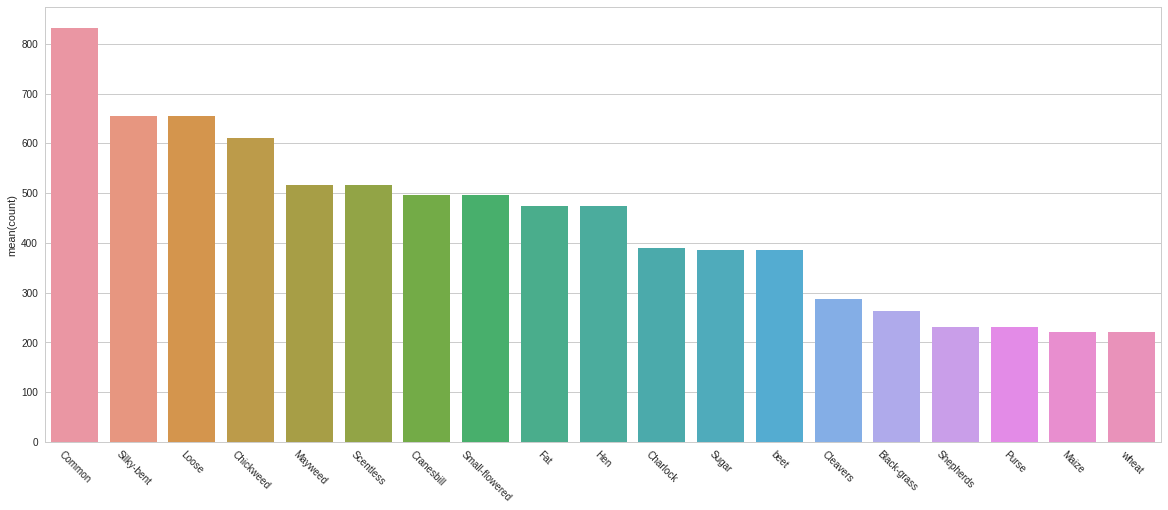

In [0]:
import seaborn as sns
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

labels = df['category'].apply(lambda x: x.split(' '))
from collections import Counter, defaultdict
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

counts_df = pd.DataFrame.from_dict(counts, orient='index')
counts_df.columns = ['count']
counts_df.sort_values('count', ascending=False, inplace=True)

fig, ax = plt.subplots()
ax = sns.barplot(x=counts_df.index, y=counts_df['count'], ax=ax)
fig.set_size_inches(20,8)
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=-45);

# PuTorch Augmentations (most of the code here was adapted from github) 

In [0]:
from torchvision.transforms import *

from PIL import Image, ImageDraw
import numpy as np
import torch

import torchvision
import random
from PIL import Image, ImageOps
import numpy as np
import numbers
import math
import torch
import torch
import random
import PIL.ImageEnhance as ie
import PIL.Image as im

# adapted from https://github.com/kuangliu/pytorch-retinanet/blob/master/transform.py
# https://github.com/mratsim/Amazon-Forest-Computer-Vision/blob/master/src/p_data_augmentation.py

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

def draw(img, boxes):
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle(list(box), outline='red')
    img.show()

def draw2(img):
    img.show()


class GroupRandomCrop(object):
    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size

    def __call__(self, img_group):

        w, h = img_group[0].size
        th, tw = self.size

        out_images = list()

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)

        for img in img_group:
            assert(img.size[0] == w and img.size[1] == h)
            if w == tw and h == th:
                out_images.append(img)
            else:
                out_images.append(img.crop((x1, y1, x1 + tw, y1 + th)))

        return out_images


class GroupCenterCrop(object):
    def __init__(self, size):
        self.worker = torchvision.transforms.CenterCrop(size)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class GroupRandomHorizontalFlip(object):
    """Randomly horizontally flips the given PIL.Image with a probability of 0.5
    """
    def __init__(self, is_flow=False):
        self.is_flow = is_flow

    def __call__(self, img_group, is_flow=False):
        v = random.random()
        if v < 0.5:
            ret = [img.transpose(Image.FLIP_LEFT_RIGHT) for img in img_group]
            if self.is_flow:
                for i in range(0, len(ret), 2):
                    ret[i] = ImageOps.invert(ret[i])  # invert flow pixel values when flipping
            return ret
        else:
            return img_group


class GroupNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        rep_mean = self.mean * (tensor.size()[0]//len(self.mean))
        rep_std = self.std * (tensor.size()[0]//len(self.std))

        # TODO: make efficient
        for t, m, s in zip(tensor, rep_mean, rep_std):
            t.sub_(m).div_(s)

        return tensor


class GroupScale(object):
    """ Rescales the input PIL.Image to the given 'size'.
    'size' will be the size of the smaller edge.
    For example, if height > width, then image will be
    rescaled to (size * height / width, size)
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.worker = torchvision.transforms.Scale(size, interpolation)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]


class GroupOverSample(object):
    def __init__(self, crop_size, scale_size=None):
        self.crop_size = crop_size if not isinstance(crop_size, int) else (crop_size, crop_size)

        if scale_size is not None:
            self.scale_worker = GroupScale(scale_size)
        else:
            self.scale_worker = None

    def __call__(self, img_group):

        if self.scale_worker is not None:
            img_group = self.scale_worker(img_group)

        image_w, image_h = img_group[0].size
        crop_w, crop_h = self.crop_size

        offsets = GroupMultiScaleCrop.fill_fix_offset(False, image_w, image_h, crop_w, crop_h)
        oversample_group = list()
        for o_w, o_h in offsets:
            normal_group = list()
            flip_group = list()
            for i, img in enumerate(img_group):
                crop = img.crop((o_w, o_h, o_w + crop_w, o_h + crop_h))
                normal_group.append(crop)
                flip_crop = crop.copy().transpose(Image.FLIP_LEFT_RIGHT)

                if img.mode == 'L' and i % 2 == 0:
                    flip_group.append(ImageOps.invert(flip_crop))
                else:
                    flip_group.append(flip_crop)

            oversample_group.extend(normal_group)
            oversample_group.extend(flip_group)
        return oversample_group


class GroupMultiScaleCrop(object):

    def __init__(self, input_size, scales=None, max_distort=1, fix_crop=True, more_fix_crop=True):
        self.scales = scales if scales is not None else [1, 875, .75, .66]
        self.max_distort = max_distort
        self.fix_crop = fix_crop
        self.more_fix_crop = more_fix_crop
        self.input_size = input_size if not isinstance(input_size, int) else [input_size, input_size]
        self.interpolation = Image.BILINEAR

    def __call__(self, img_group):

        im_size = img_group[0].size

        crop_w, crop_h, offset_w, offset_h = self._sample_crop_size(im_size)
        crop_img_group = [img.crop((offset_w, offset_h, offset_w + crop_w, offset_h + crop_h)) for img in img_group]
        ret_img_group = [img.resize((self.input_size[0], self.input_size[1]), self.interpolation)
                         for img in crop_img_group]
        return ret_img_group

    def _sample_crop_size(self, im_size):
        image_w, image_h = im_size[0], im_size[1]

        # find a crop size
        base_size = min(image_w, image_h)
        crop_sizes = [int(base_size * x) for x in self.scales]
        crop_h = [self.input_size[1] if abs(x - self.input_size[1]) < 3 else x for x in crop_sizes]
        crop_w = [self.input_size[0] if abs(x - self.input_size[0]) < 3 else x for x in crop_sizes]

        pairs = []
        for i, h in enumerate(crop_h):
            for j, w in enumerate(crop_w):
                if abs(i - j) <= self.max_distort:
                    pairs.append((w, h))

        crop_pair = random.choice(pairs)
        if not self.fix_crop:
            w_offset = random.randint(0, image_w - crop_pair[0])
            h_offset = random.randint(0, image_h - crop_pair[1])
        else:
            w_offset, h_offset = self._sample_fix_offset(image_w, image_h, crop_pair[0], crop_pair[1])

        return crop_pair[0], crop_pair[1], w_offset, h_offset

    def _sample_fix_offset(self, image_w, image_h, crop_w, crop_h):
        offsets = self.fill_fix_offset(self.more_fix_crop, image_w, image_h, crop_w, crop_h)
        return random.choice(offsets)

    @staticmethod
    def fill_fix_offset(more_fix_crop, image_w, image_h, crop_w, crop_h):
        w_step = (image_w - crop_w) // 4
        h_step = (image_h - crop_h) // 4

        ret = list()
        ret.append((0, 0))  # upper left
        ret.append((4 * w_step, 0))  # upper right
        ret.append((0, 4 * h_step))  # lower left
        ret.append((4 * w_step, 4 * h_step))  # lower right
        ret.append((2 * w_step, 2 * h_step))  # center

        if more_fix_crop:
            ret.append((0, 2 * h_step))  # center left
            ret.append((4 * w_step, 2 * h_step))  # center right
            ret.append((2 * w_step, 4 * h_step))  # lower center
            ret.append((2 * w_step, 0 * h_step))  # upper center

            ret.append((1 * w_step, 1 * h_step))  # upper left quarter
            ret.append((3 * w_step, 1 * h_step))  # upper right quarter
            ret.append((1 * w_step, 3 * h_step))  # lower left quarter
            ret.append((3 * w_step, 3 * h_step))  # lower righ quarter

        return ret


class GroupRandomSizedCrop(object):
    """Random crop the given PIL.Image to a random size of (0.08 to 1.0) of the original size
    and and a random aspect ratio of 3/4 to 4/3 of the original aspect ratio
    This is popularly used to train the Inception networks
    size: size of the smaller edge
    interpolation: Default: PIL.Image.BILINEAR
    """
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img_group):
        for attempt in range(10):
            area = img_group[0].size[0] * img_group[0].size[1]
            target_area = random.uniform(0.08, 1.0) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= img_group[0].size[0] and h <= img_group[0].size[1]:
                x1 = random.randint(0, img_group[0].size[0] - w)
                y1 = random.randint(0, img_group[0].size[1] - h)
                found = True
                break
        else:
            found = False
            x1 = 0
            y1 = 0

        if found:
            out_group = list()
            for img in img_group:
                img = img.crop((x1, y1, x1 + w, y1 + h))
                assert(img.size == (w, h))
                out_group.append(img.resize((self.size, self.size), self.interpolation))
            return out_group
        else:
            # Fallback
            scale = GroupScale(self.size, interpolation=self.interpolation)
            crop = GroupRandomCrop(self.size)
            return crop(scale(img_group))


class Stack(object):

    def __init__(self, roll=False):
        self.roll = roll

    def __call__(self, img_group):
        if img_group[0].mode == 'L':
            return np.concatenate([np.expand_dims(x, 2) for x in img_group], axis=2)
        elif img_group[0].mode == 'RGB':
            if self.roll:
                return np.concatenate([np.array(x)[:, :, ::-1] for x in img_group], axis=2)
            else:
                return np.concatenate(img_group, axis=2)


class ToTorchFormatTensor(object):
    """ Converts a PIL.Image (RGB) or numpy.ndarray (H x W x C) in the range [0, 255]
    to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] """
    def __init__(self, div=True):
        self.div = div

    def __call__(self, pic):
        if isinstance(pic, np.ndarray):
            # handle numpy array
            img = torch.from_numpy(pic).permute(2, 0, 1).contiguous()
        else:
            # handle PIL Image
            img = torch.ByteTensor(torch.ByteStorage.from_buffer(pic.tobytes()))
            img = img.view(pic.size[1], pic.size[0], len(pic.mode))
            # put it from HWC to CHW format
            # yikes, this transpose takes 80% of the loading time/CPU
            img = img.transpose(0, 1).transpose(0, 2).contiguous()
        return img.float().div(255) if self.div else img.float()


class IdentityTransform(object):

    def __call__(self, data):
        return data

class RandomErasing(object):
    def __init__(self, EPSILON = 0.5, sl = 0.02, sh = 0.4, r1 = 0.3, mean=[0.4914, 0.4822, 0.4465]):
        self.EPSILON = EPSILON
        self.mean = mean
        self.sl = sl
        self.sh = sh
        self.r1 = r1
       
    def __call__(self, img):

        if random.uniform(0, 1) > self.EPSILON:
            return img

        for attempt in range(100):
            area = img.size()[1] * img.size()[2]
       
            target_area = random.uniform(self.sl, self.sh) * area
            aspect_ratio = random.uniform(self.r1, 1/self.r1)

            h = int(round(math.sqrt(target_area * aspect_ratio)))
            w = int(round(math.sqrt(target_area / aspect_ratio)))

            if w <= img.size()[2] and h <= img.size()[1]:
                x1 = random.randint(0, img.size()[1] - h)
                y1 = random.randint(0, img.size()[2] - w)
                if img.size()[0] == 3:
                    #img[0, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[1, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    #img[2, x1:x1+h, y1:y1+w] = random.uniform(0, 1)
                    img[0, x1:x1+h, y1:y1+w] = self.mean[0]
                    img[1, x1:x1+h, y1:y1+w] = self.mean[1]
                    img[2, x1:x1+h, y1:y1+w] = self.mean[2]
                    #img[:, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(3, h, w))
                else:
                    img[0, x1:x1+h, y1:y1+w] = self.mean[1]
                    # img[0, x1:x1+h, y1:y1+w] = torch.from_numpy(np.random.rand(1, h, w))
                return img

        return img

def random_crop(img, boxes):
    '''Crop the given PIL image to a random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made.
    Args:
      img: (PIL.Image) image to be cropped.
      boxes: (tensor) object boxes, sized [#ojb,4].
    Returns:
      img: (PIL.Image) randomly cropped image.
      boxes: (tensor) randomly cropped boxes.
    '''
    success = False
    for attempt in range(10):
        area = img.size[0] * img.size[1]
        target_area = random.uniform(0.56, 1.0) * area
        aspect_ratio = random.uniform(3. / 4, 4. / 3)

        w = int(round(math.sqrt(target_area * aspect_ratio)))
        h = int(round(math.sqrt(target_area / aspect_ratio)))

        if random.random() < 0.5:
            w, h = h, w

        if w <= img.size[0] and h <= img.size[1]:
            x = random.randint(0, img.size[0] - w)
            y = random.randint(0, img.size[1] - h)
            success = True
            break

    # Fallback
    if not success:
        w = h = min(img.size[0], img.size[1])
        x = (img.size[0] - w) // 2
        y = (img.size[1] - h) // 2

    img = img.crop((x, y, x+w, y+h))
    boxes -= torch.Tensor([x,y,x,y])
    boxes[:,0::2].clamp_(min=0, max=w-1)
    boxes[:,1::2].clamp_(min=0, max=h-1)
    return img, boxes


class Lighting(object):
    """Lighting noise(AlexNet - style PCA - based noise)"""

    def __init__(self, alphastd, eigval, eigvec):
        self.alphastd = alphastd
        self.eigval = eigval
        self.eigvec = eigvec

    def __call__(self, img):
        if self.alphastd == 0:
            return img

        alpha = img.new().resize_(3).normal_(0, self.alphastd)
        rgb = self.eigvec.type_as(img).clone() \
            .mul(alpha.view(1, 3).expand(3, 3)) \
            .mul(self.eigval.view(1, 3).expand(3, 3)) \
            .sum(1).squeeze()

        return img.add(rgb.view(3, 1, 1).expand_as(img))


class Grayscale(object):
    def __call__(self, img):
        gs = img.clone()
        gs[0].mul_(0.299).add_(0.587, gs[1]).add_(0.114, gs[2])
        gs[1].copy_(gs[0])
        gs[2].copy_(gs[0])
        return gs


class Saturation(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Brightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = img.new().resize_as_(img).zero_()
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class Contrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        gs = Grayscale()(img)
        gs.fill_(gs.mean())
        alpha = random.uniform(0, self.var)
        return img.lerp(gs, alpha)


class RandomOrder(object):
    """ Composes several transforms together in random order.
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        if self.transforms is None:
            return img
        order = torch.randperm(len(self.transforms))
        for i in order:
            img = self.transforms[i](img)
        return img


class ColorJitter(RandomOrder):
    def __init__(self, brightness=0.4, contrast=0.4, saturation=0.4):
        self.transforms = []
        if brightness != 0:
            self.transforms.append(Brightness(brightness))
        if contrast != 0:
            self.transforms.append(Contrast(contrast))
        if saturation != 0:
            self.transforms.append(Saturation(saturation))


class RandomFlip(object):
    """Randomly flips the given PIL.Image with a probability of 0.25 horizontal,
                                                                0.25 vertical,
                                                                0.5 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img.transpose(im.FLIP_LEFT_RIGHT),
            3: img.transpose(im.FLIP_TOP_BOTTOM)
        }

        return dispatcher[random.randint(0, 3)]  # randint is inclusive


class RandomRotate(object):
    """Randomly rotate the given PIL.Image with a probability of 1/6 90°,
                                                                 1/6 180°,
                                                                 1/6 270°,
                                                                 1/2 as is
    """

    def __call__(self, img):
        dispatcher = {
            0: img,
            1: img,
            2: img,
            3: img.transpose(im.ROTATE_90),
            4: img.transpose(im.ROTATE_180),
            5: img.transpose(im.ROTATE_270)
        }

        return dispatcher[random.randint(0, 5)]  # randint is inclusive


class PILColorBalance(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Color(img).enhance(alpha)


class PILContrast(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Contrast(img).enhance(alpha)


class PILBrightness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Brightness(img).enhance(alpha)


class PILSharpness(object):
    def __init__(self, var):
        self.var = var

    def __call__(self, img):
        alpha = random.uniform(1 - self.var, 1 + self.var)
        return ie.Sharpness(img).enhance(alpha)


# Check ImageEnhancer effect: https://www.youtube.com/watch?v=_7iDTpTop04
# Not documented but all enhancements can go beyond 1.0 to 2
# Image must be RGB
# Use Pillow-SIMD because Pillow is too slow
class PowerPIL(RandomOrder):
    def __init__(self, rotate=True,
                 flip=True,
                 colorbalance=0.4,
                 contrast=0.4,
                 brightness=0.4,
                 sharpness=0.4):
        self.transforms = []
        if rotate:
            self.transforms.append(RandomRotate())
        if flip:
            self.transforms.append(RandomFlip())
        if brightness != 0:
            self.transforms.append(PILBrightness(brightness))
        if contrast != 0:
            self.transforms.append(PILContrast(contrast))
        if colorbalance != 0:
            self.transforms.append(PILColorBalance(colorbalance))
        if sharpness != 0:
            self.transforms.append(PILSharpness(sharpness))



# Setup transforms, datasets, and dataloaders

- Data loaders spit out data from a dataset in batches. This is what you actually feed the neural network during training.

{'train': 4038, 'valid': 712}
6     544
3     512
8     441
10    427
5     406
11    336
1     333
2     249
0     220
9     195
4     195
7     180
Name: category_id, dtype: int64


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


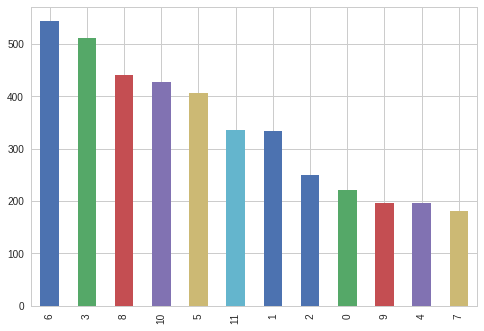

In [0]:
image_size = 224

normalize_img = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


train_trans = transforms.Compose([
    transforms.RandomSizedCrop(image_size),
    PowerPIL(),
    transforms.ToTensor(),
#     normalize_img,
    RandomErasing()
])

## Normalization only for validation and test
valid_trans = transforms.Compose([
    transforms.Scale(256),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
#     normalize_img
])

batch_size = 8
train_data = df.sample(frac=0.85)
valid_data = df[~df['file'].isin(train_data['file'])]

train_set = GenericDataset(train_data, data_dir, transform = train_trans)
valid_set = GenericDataset(valid_data, data_dir, transform = valid_trans)
        

t_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=1)
v_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=1)
# test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

dataset_sizes = {
    'train': len(t_loader.dataset), 
    'valid': len(v_loader.dataset)
}


print (dataset_sizes)
print (train_data["category_id"].value_counts())

train_data['category_id'].value_counts().plot(kind='bar')

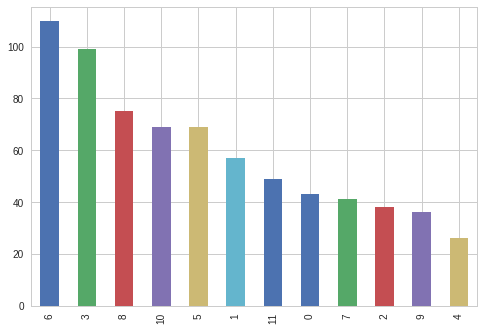

In [0]:
valid_data['category_id'].value_counts().plot(kind='bar')

### Test the DataLoader Class

i=0: 
i=1: 
i=2: 
i=3: 


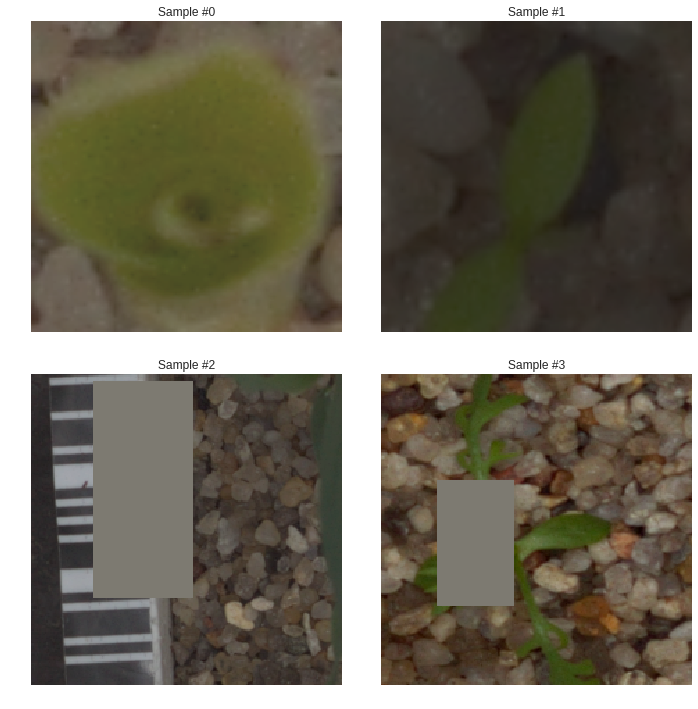

In [0]:
# module 'PIL.Image' has no attribute 'register_extensions'

#!pip install Pillow==4.0.0
#!pip install PIL
#!pip install image

imagesToShow=4

def flaotTensorToImage(img, mean=0, std=1):
        """convert a tensor to an image"""
        img = np.transpose(img.numpy(), (1, 2, 0))
        img = (img*std+ mean)*255
        img = img.astype(np.uint8)    
        return img   
      
plt.figure(figsize=[10,10])
# if __name__ == '__main__':  
for i, data in enumerate(t_loader, 0):
    print('i=%d: '%(i))            
    images, labels = data            
    num = len(images)
   
    ax = plt.subplot(2,2, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')

    for n in range(num):
        image=images[n]
        label=labels[n]
        plt.imshow (flaotTensorToImage(image))

    if i==imagesToShow-1:
        break

# Define the model

## Dual Path Network (DPN92)
- https://github.com/rwightman/pytorch-dpn-pretrained

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import math 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import OrderedDict
from torch.nn import init
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict

__all__ = ['DPN', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'dpns']


def dpn92(num_classes=1000):
    return DPN(num_init_features=64, k_R=96, G=32, k_sec=(3,4,20,3), inc_sec=(16,32,24,128), num_classes=num_classes)


def dpn98(num_classes=1000):
    return DPN(num_init_features=96, k_R=160, G=40, k_sec=(3,6,20,3), inc_sec=(16,32,32,128), num_classes=num_classes)


def dpn131(num_classes=1000):
    return DPN(num_init_features=128, k_R=160, G=40, k_sec=(4,8,28,3), inc_sec=(16,32,32,128), num_classes=num_classes)


def dpn107(num_classes=1000):
    return DPN(num_init_features=128, k_R=200, G=50, k_sec=(4,8,20,3), inc_sec=(20,64,64,128), num_classes=num_classes)


dpns = {
    'dpn92': dpn92,
    'dpn98': dpn98,
    'dpn107': dpn107,
    'dpn131': dpn131,
}


class DualPathBlock(nn.Module):
    def __init__(self, in_chs, num_1x1_a, num_3x3_b, num_1x1_c, inc, G, _type='normal'):
        super(DualPathBlock, self).__init__()
        self.num_1x1_c = num_1x1_c

        if _type is 'proj':
            key_stride = 1
            self.has_proj = True
        if _type is 'down':
            key_stride = 2
            self.has_proj = True
        if _type is 'normal':
            key_stride = 1
            self.has_proj = False

        if self.has_proj:
            self.c1x1_w = self.BN_ReLU_Conv(in_chs=in_chs, out_chs=num_1x1_c+2*inc, kernel_size=1, stride=key_stride)

        self.layers = nn.Sequential(OrderedDict([
            ('c1x1_a', self.BN_ReLU_Conv(in_chs=in_chs, out_chs=num_1x1_a, kernel_size=1, stride=1)),
            ('c3x3_b', self.BN_ReLU_Conv(in_chs=num_1x1_a, out_chs=num_3x3_b, kernel_size=3, stride=key_stride, padding=1, groups=G)),
            ('c1x1_c', self.BN_ReLU_Conv(in_chs=num_3x3_b, out_chs=num_1x1_c+inc, kernel_size=1, stride=1)),
        ]))

    def BN_ReLU_Conv(self, in_chs, out_chs, kernel_size, stride, padding=0, groups=1):
        return nn.Sequential(OrderedDict([
            ('norm', nn.BatchNorm2d(in_chs)),
            ('relu', nn.ReLU(inplace=True)),
            ('conv', nn.Conv2d(in_chs, out_chs, kernel_size, stride, padding, groups=groups, bias=False)),
        ]))

    def forward(self, x):
        data_in = torch.cat(x, dim=1) if isinstance(x, list) else x
        if self.has_proj:
            data_o = self.c1x1_w(data_in)
            data_o1 = data_o[:,:self.num_1x1_c,:,:]
            data_o2 = data_o[:,self.num_1x1_c:,:,:]
        else:
            data_o1 = x[0]
            data_o2 = x[1]

        out = self.layers(data_in)

        summ = data_o1 + out[:,:self.num_1x1_c,:,:]
        dense = torch.cat([data_o2, out[:,self.num_1x1_c:,:,:]], dim=1)
        return [summ, dense]


class DPN(nn.Module):

    def __init__(self, num_init_features=64, k_R=96, G=32,
                 k_sec=(3, 4, 20, 3), inc_sec=(16,32,24,128), num_classes=1000):

        super(DPN, self).__init__()
        blocks = OrderedDict()

        # conv1
        blocks['conv1'] = nn.Sequential(
            nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(num_init_features),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # conv2
        bw = 256
        inc = inc_sec[0]
        R = int((k_R*bw)/256)
        blocks['conv2_1'] = DualPathBlock(num_init_features, R, R, bw, inc, G, 'proj')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[0]+1):
            blocks['conv2_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv3
        bw = 512
        inc = inc_sec[1]
        R = int((k_R*bw)/256)
        blocks['conv3_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[1]+1):
            blocks['conv3_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv4
        bw = 1024
        inc = inc_sec[2]
        R = int((k_R*bw)/256)
        blocks['conv4_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[2]+1):
            blocks['conv4_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        # conv5
        bw = 2048
        inc = inc_sec[3]
        R = int((k_R*bw)/256)
        blocks['conv5_1'] = DualPathBlock(in_chs, R, R, bw, inc, G, 'down')
        in_chs = bw + 3 * inc
        for i in range(2, k_sec[3]+1):
            blocks['conv5_{}'.format(i)] = DualPathBlock(in_chs, R, R, bw, inc, G, 'normal')
            in_chs += inc

        self.features = nn.Sequential(blocks)
        self.classifier = nn.Linear(in_chs, num_classes)


    def forward(self, x):
        features = torch.cat(self.features(x), dim=1)
        out = F.avg_pool2d(features, kernel_size=7).view(features.size(0), -1)
        # print (out.data.shape)
        out = self.classifier(out)
        return out


# model = SimpleNet(len(classes), 3)
# model =vggnetXX_generic(len(classes), 3)
# model =lenetXX_generic(len(classes), 3)
# model =resnetxtXX_generic(len(classes), 3)
# model =wrnXX_generic(len(classes), 3)
model =dpn92(len(classes))
# model = senetXX_generic(len(classes), 3, 32)


criterion = torch.nn.CrossEntropyLoss()
lr= 0.00005 * 2 * 2
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

if use_cuda:
    model = model.cuda()
# model = senetXX_generic(len(classes), 3, 32)
model_name = (type(model).__name__) # remember the real name
# model = torch.nn.DataParallel(model, device_ids=list(range(4)))
print(model)

DPN(
  (features): Sequential(
    (conv1): Sequential(
      (0): Conv2d (3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
    )
    (conv2_1): DualPathBlock(
      (c1x1_w): Sequential(
        (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU(inplace)
        (conv): Conv2d (64, 288, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (layers): Sequential(
        (c1x1_a): Sequential(
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv): Conv2d (64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (c3x3_b): Sequential(
          (norm): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True)
          (relu): ReLU(inplace)
          (conv): Conv2d (96, 96, ker

# Metrics, and Plots

In [0]:
import datetime 

NOW_TIME = datetime.datetime.now()
NOW_TIME =NOW_TIME.strftime("%Y-%m-%d %H:%M")

import os, sys, time
import numpy as np
import matplotlib
import torch
import random

# matplotlib.use('agg')
import matplotlib.pyplot as plt

class AverageMeter(object):
  """Computes and stores the average and current value"""
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count


def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60.
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

class RecorderMeter(object):
    """Computes and stores the minimum loss value and its epoch index"""

    def __init__(self, total_epoch):
        self.reset(total_epoch)

    def reset(self, total_epoch):
        assert total_epoch > 0
        self.total_epoch = total_epoch
        self.current_epoch = 0
        self.epoch_losses = np.zeros((self.total_epoch, 2), dtype=np.float32)  # [epoch, train/val]
        self.epoch_losses = self.epoch_losses - 1

        self.epoch_accuracy = np.zeros((self.total_epoch, 2), dtype=np.float32)  # [epoch, train/val]
        self.epoch_accuracy = self.epoch_accuracy

    def update(self, idx, train_loss, train_acc, val_loss, val_acc):
        assert idx >= 0 and idx < self.total_epoch, 'total_epoch : {} , but update with the {} index'.format(
            self.total_epoch, idx)
        self.epoch_losses[idx, 0] = train_loss
        self.epoch_losses[idx, 1] = val_loss
        self.epoch_accuracy[idx, 0] = train_acc
        self.epoch_accuracy[idx, 1] = val_acc
        self.current_epoch = idx + 1
        return self.max_accuracy(False) == val_acc

    def max_accuracy(self, istrain):
        if self.current_epoch <= 0: return 0
        if istrain:
            return self.epoch_accuracy[:self.current_epoch, 0].max()
        else:
            return self.epoch_accuracy[:self.current_epoch, 1].max()


    def plot_curve(self, save_path, training_time, model, model_name, s_size,batch_size, learning_rate,dataset,manualSeed,num_classes):
        title = 'PyTorch T-TIME:{}'.format(hms_string(training_time)) + ',Net:' + str(model_name).upper() + ',LR:' + str(learning_rate) +  ',DataSet:' + str(dataset).upper() + ',' + '\n'\
                + ',Params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0) + ',Seed: %.2f' % manualSeed + \
                ",Torch: {}".format(torch.__version__) + ", Batch:{}".format(batch_size) + ", Samples:{}".format(s_size) +  ", Classes:{}".format(num_classes)

        dpi = 80
        width, height = 1200, 800
        legend_fontsize = 14
        scale_distance = 48.8
        figsize = width / float(dpi), height / float(dpi)

        fig = plt.figure(figsize=figsize)
        x_axis = np.array([i for i in range(self.total_epoch)])  # epochs
        y_axis = np.zeros(self.total_epoch)

        plt.xlim(0, self.total_epoch)
        plt.ylim(0, 1.0)
        interval_y = 0.05 / 3.0
        interval_x = 1
        plt.xticks(np.arange(0, self.total_epoch + interval_x, interval_x))
        plt.yticks(np.arange(0, 1.0 + interval_y, interval_y))
        plt.grid()
        plt.title(title, fontsize=18)
        plt.xlabel('EPOCH', fontsize=16)
        plt.ylabel('LOSS/ACC', fontsize=16)

        y_axis[:] = self.epoch_accuracy[:, 0] / 100.0
        plt.plot(x_axis, y_axis, color='g', linestyle='-', label='tr-accuracy/100', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_accuracy[:, 1] / 100.0
        plt.plot(x_axis, y_axis, color='y', linestyle='-', label='val-accuracy/100', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 0]
        plt.plot(x_axis, y_axis, color='r', linestyle=':', label='tr-loss', lw=2)
        plt.legend(loc=4, fontsize=legend_fontsize)

        y_axis[:] = self.epoch_losses[:, 1]
        plt.plot(x_axis, y_axis, color='b', linestyle=':', label='val-loss', lw=4)
        plt.legend(loc=4, fontsize=legend_fontsize)

        if save_path is not None:
            fig.savefig(save_path, dpi=dpi, bbox_inches='tight')
            # print('---- save figure {} into {}'.format(title, save_path))
        plt.close(fig)

def time_string():
  ISOTIMEFORMAT='%Y-%m-%d %X'
  string = '[{}]'.format(time.strftime( ISOTIMEFORMAT, time.gmtime(time.time()) ))
  return string

def convert_secs2time(epoch_time):
  need_hour = int(epoch_time / 3600)
  need_mins = int((epoch_time - 3600*need_hour) / 60)
  need_secs = int(epoch_time - 3600*need_hour - 60*need_mins)
  return need_hour, need_mins, need_secs

def time_file_str():
  ISOTIMEFORMAT='%Y-%m-%d'
  string = '{}'.format(time.strftime( ISOTIMEFORMAT, time.gmtime(time.time()) ))
  return string + '-{}'.format(random.randint(1, 10000))

def accuracy2(output, target, topk=(1,)):
  """Computes the precision@k for the specified values of k"""
  maxk = max(topk)
  batch_size = target.size(0)

  _, pred = output.topk(maxk, 1, True, True)
  pred = pred.t()
  correct = pred.eq(target.view(1, -1).expand_as(pred))

  res = []
  for k in topk:
    correct_k = correct[:k].view(-1).float().sum(0)
    res.append(correct_k.mul_(100.0 / batch_size))
  return res

### Training

In [0]:
from tqdm import tqdm 
from sklearn import metrics
import torch
import numpy as np
from sklearn import cross_validation
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, roc_auc_score, roc_curve, auc

def train(train_loader, model, epoch, optimizer):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()
   
    # switch to train mode
    model.train()

    end = time.time()
    for batch_idx, (images, target) in enumerate(train_loader): 
        correct = 0
        # measure data loading time
        data_time.update(time.time() - end)

        if use_cuda:
            images, target = images.cuda(), target.cuda()
            images, target = Variable(images), Variable(target)
        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, target)

        # measure accuracy and record loss
        prec1, prec1 = accuracy2(y_pred.data, target.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))
        
        pred = y_pred.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()
        accuracy = 100. * correct / len(images)
        
        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if batch_idx % 200  == 0:
            print('TRAIN: LOSS-->{loss.val:.4f} ({loss.avg:.4f})\t' 'ACC-->{acc.val:.3f}% ({acc.avg:.3f}%)'.format(loss=losses, acc=acc))
            if use_tensorboard:
                exp.add_scalar_value('tr_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('tr_epoch_acc', acc.avg, step=epoch)
                
            print('TRAIN: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {}/{} ({:.3f}%)'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0],
                correct, len(images),
                accuracy))            
    

    return float('{loss.avg:.4f}'.format(loss=losses)), float('{acc.avg:.4f}'.format(acc=acc))

def validate(val_loader, model, epoch):
    if use_cuda:
        model.cuda()
        criterion.cuda()

    batch_time = AverageMeter()
    losses = AverageMeter()
    acc = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (images, labels) in enumerate(val_loader):

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
            images, labels = Variable(images, volatile=True), Variable(labels)

        # compute y_pred
        y_pred = model(images)
        loss = criterion(y_pred, labels)

        # measure accuracy and record loss
        prec1, temp_var = accuracy2(y_pred.data, labels.data, topk=(1, 1))
        losses.update(loss.data[0], images.size(0))
        acc.update(prec1[0], images.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 200== 0:
            print('VAL:   LOSS--> {loss.val:.4f} ({loss.avg:.4f})\t''ACC-->{acc.val:.3f} ({acc.avg:.3f})'.format(loss=losses, acc=acc))

        if i % 50 == 0:
            if use_tensorboard:
                exp.add_scalar_value('val_epoch_loss', losses.avg, step=epoch)
                exp.add_scalar_value('val_epoch_acc', acc.avg, step=epoch)

    print(' * Accuracy {acc.avg:.4f}'.format(acc=acc))
    return float('{loss.avg:.6f}'.format(loss=losses)), float('{acc.avg:.6f}'.format(acc=acc))


def testImageLoader(image_name):
    """load image, returns cuda tensor"""
#     image = Image.open(image_name)
    image = Image.open(image_name).convert('RGB')
    image = test_trans(image)
#     image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  
    if use_cuda:
#         print ("cuda")
        image.cuda()         
    return image  

def testModel(test_dir, local_model):    
    if use_cuda:
        local_model.cuda()
    
    local_model.eval()
    
    columns = ['file', 'species']
    df_pred = pd.DataFrame(data=np.zeros((0, len(columns))), columns=columns)
#     df_pred.species.astype(int)
    for index, row in (sample_submission.iterrows()):
#         for file in os.listdir(test_dir):            
        currImage=os.path.join(test_dir, row['file'])
        if os.path.isfile(currImage):
            X_tensor_test=testImageLoader (currImage)            
#             print (type(X_tensor_test))
            if use_cuda:
                X_tensor_test = Variable(X_tensor_test.cuda()) 
            else:
                X_tensor_test = Variable(X_tensor_test)        
            
            # get the index of the max log-probability
            predicted_val = (local_model(X_tensor_test)).data.max(1)[1] # get the index of the max log-probability
#             predicted_val = predicted_val.data.max(1, keepdim=True)[1]
            p_test = (predicted_val.cpu().numpy().item())
            df_pred = df_pred.append({'file': row['file'], 'species': num_to_class[int(p_test)]}, ignore_index=True)             
    
    return df_pred

# Train the model
 - You should use 150 epohcs to get good results,e.g 95% accuracy 
 - Here I only used 5 epochs becuase of google collab

In [0]:
use_tensorboard=False 

sample_submission = pd.read_csv('sample_submission.csv')
sample_submission.columns = ['file', 'species']
# sample_submission['category_id'] = 0
sample_submission.head(3)

test_trans = valid_trans
test_data_dir = 'test/'

if __name__ == '__main__':  
    epochs=50
    runId = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')    
    recorder = RecorderMeter(epochs)  # epoc is updated
#     model_name = (type(model).__name__)

    exp_name = datetime.datetime.now().strftime(model_name + '_' + dataset + '_%Y-%m-%d_%H-%M-%S')    
    mPath = './logs' + '/' + dataset + '/' + model_name + '/'    
    if not os.path.isdir(mPath):
        os.makedirs(mPath)    
    print("Random Seed: {}".format(manualSeed))
    print("python version : {}".format(sys.version.replace('\n', ' ')))
    print("torch  version : {}".format(torch.__version__))
    print("cudnn  version : {}".format(torch.backends.cudnn.version()))    
    print("=> Final model name '{}'".format(model_name))            
    print ("MODEL: {}".format( str(model_name)))
    print ("dataset: {}".format(dataset))
    print('    Total params: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))    
    
    print ("MODEL: {}".format( str(type(model).__name__)))
    
    start_training_time = time.time()
    training_time=time.time()
    for epoch in tqdm(range(0, epochs)):        
        train_result, accuracy_tr=train(t_loader, model, epoch, optimizer)
        val_loss, val_accuracy= validate(v_loader, model, epoch)  
        
        recorder.update(epoch, train_result, accuracy_tr, val_loss, val_accuracy) 
        training_time=time.time() - start_training_time
        recorder.plot_curve(os.path.join(mPath, model_name + '_' + exp_name + '.png'),training_time, model, model_name,
                            str(dataset_sizes),
                        batch_size, lr,dataset,manualSeed,len(classes))
        
        if float(val_accuracy) > float(95.0):            
            print ("EARLY STOP")            
            df_pred=testModel(test_data_dir,model)
            df_pred.to_csv(str(type(model).__name__) + '_' + str(val_accuracy) + '_' + 
                           str(epoch) + "_sub.csv", columns=('file', 'species'), index=None)
            torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + '_.pth'))                        

  0%|          | 0/50 [00:00<?, ?it/s]

Random Seed: 999
python version : 3.6.3 (default, Oct  3 2017, 21:45:48)  [GCC 7.2.0]
torch  version : 0.3.0.post4
cudnn  version : 7003
=> Final model name 'DPN'
MODEL: DPN
dataset: seedlings
    Total params: 35.01M
MODEL: DPN
TRAIN: LOSS-->2.3890 (2.3890)	ACC-->25.000% (25.000%)
TRAIN: 0 [0/4038 (0%)]	Loss: 2.389049, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->2.0954 (2.5170)	ACC-->12.500% (15.423%)
TRAIN: 0 [1600/4038 (40%)]	Loss: 2.095412, Accuracy: 1/8 (12.500%)
TRAIN: LOSS-->1.7438 (2.3310)	ACC-->37.500% (21.166%)
TRAIN: 0 [3200/4038 (79%)]	Loss: 1.743755, Accuracy: 3/8 (37.500%)
VAL:   LOSS--> 1.2493 (1.2493)	ACC-->62.500 (62.500)
 * Accuracy 38.4831


  2%|▏         | 1/50 [04:44<3:52:24, 284.58s/it]

TRAIN: LOSS-->1.8635 (1.8635)	ACC-->37.500% (37.500%)
TRAIN: 1 [0/4038 (0%)]	Loss: 1.863465, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->2.0895 (2.0065)	ACC-->25.000% (31.779%)
TRAIN: 1 [1600/4038 (40%)]	Loss: 2.089512, Accuracy: 2/8 (25.000%)
TRAIN: LOSS-->2.1335 (1.9580)	ACC-->25.000% (33.416%)
TRAIN: 1 [3200/4038 (79%)]	Loss: 2.133490, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 2.7261 (2.7261)	ACC-->25.000 (25.000)
 * Accuracy 30.7584


  4%|▍         | 2/50 [09:29<3:47:45, 284.70s/it]

TRAIN: LOSS-->1.2925 (1.2925)	ACC-->50.000% (50.000%)
TRAIN: 2 [0/4038 (0%)]	Loss: 1.292541, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.9857 (1.8644)	ACC-->37.500% (37.251%)
TRAIN: 2 [1600/4038 (40%)]	Loss: 1.985693, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.8972 (1.8458)	ACC-->25.000% (36.814%)
TRAIN: 2 [3200/4038 (79%)]	Loss: 1.897186, Accuracy: 2/8 (25.000%)
VAL:   LOSS--> 1.3100 (1.3100)	ACC-->37.500 (37.500)
 * Accuracy 53.2303


  6%|▌         | 3/50 [14:14<3:43:08, 284.87s/it]

TRAIN: LOSS-->2.0805 (2.0805)	ACC-->37.500% (37.500%)
TRAIN: 3 [0/4038 (0%)]	Loss: 2.080542, Accuracy: 3/8 (37.500%)
TRAIN: LOSS-->1.1060 (1.7257)	ACC-->62.500% (39.428%)
TRAIN: 3 [1600/4038 (40%)]	Loss: 1.106038, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.3845 (1.7054)	ACC-->50.000% (41.085%)
TRAIN: 3 [3200/4038 (79%)]	Loss: 1.384529, Accuracy: 4/8 (50.000%)
VAL:   LOSS--> 0.8465 (0.8465)	ACC-->75.000 (75.000)
 * Accuracy 57.4438


  8%|▊         | 4/50 [18:59<3:38:24, 284.89s/it]

TRAIN: LOSS-->1.6768 (1.6768)	ACC-->62.500% (62.500%)
TRAIN: 4 [0/4038 (0%)]	Loss: 1.676762, Accuracy: 5/8 (62.500%)
TRAIN: LOSS-->1.5343 (1.5876)	ACC-->50.000% (45.025%)
TRAIN: 4 [1600/4038 (40%)]	Loss: 1.534315, Accuracy: 4/8 (50.000%)
TRAIN: LOSS-->1.5523 (1.5777)	ACC-->25.000% (46.509%)
TRAIN: 4 [3200/4038 (79%)]	Loss: 1.552271, Accuracy: 2/8 (25.000%)


In [0]:
torch.save(model.state_dict(), os.path.join(mPath, model_name + '_' + runId + '_' + str(val_accuracy) + 'FINAL_.pth'))

In this step, participants will be asked to provide the following classification rates:

-- TP (True Positive, which is the number of OP people correctly identified),

-- FP (False Positive, which is the number of CT people incorrectly identified),

-- TN (True Negative, which is the number of CT people correctly identified),

-- FN (False Negative, which is the number of OP people incorrectly identified),

-- Sn (True positive rate or sensitivity) as Sn = TP/(TP + FN),

-- Sp (Specificity or True Negative Rate) as Sp = TN/(FP + TN).

## Confusion matrix code, from the scikit documentation

In [0]:
test_trans = valid_trans
test_data_dir = 'test/'

import itertools

# Performance monitoring
from time import process_time
import matplotlib.pyplot as plt
import numpy as np
%matplotlib nbagg
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def confusion_diagnostic(model) :
    "Displays a synthetic matrix, which represents our classifier performances."
    y_test    = [] ; y_pred    = [] ; 
    for data, target in v_loader: # We won't load the testing dataset all at once:
        # Load the data on the GPU if needed, and wrap it into an autodiff object ----
        if use_cuda: data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        # Evaluation of our model on the test mini-batch -----------------------------
        output     = model(data) # Forward pass through the model
        pred       = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        y_test.append(target.data.cpu().numpy()) ; y_pred.append(pred.view(-1).cpu().numpy())
    y_test = np.hstack(y_test) ; y_pred = np.hstack(y_pred)
    
    # Display --------------------------------------------------------------------   
    cnf_matrix = confusion_matrix(y_test, y_pred)
    fig = plt.figure(dpi=150)
    plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='Confusion matrix')
    fig.canvas.draw()